<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#kmeans-구현" data-toc-modified-id="kmeans-구현-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>kmeans 구현</a></span></li></ul></div>

**텐서**
* 동적 크기를 갖는 다차원 자료구조
* 차원 표기법
    * 구조(shape): [D0, D1, ... Dn-1]
    * 랭크(rank): n
    * 차원번호(dimension number): n-D
* 변수와 상수 선언
    * 변수: `tf.variable()`
    * 상수: `tf.constant()`
    * 변수 초기화: `tf.global_variables_initializer()`
    * 심벌릭 변수
        * 프로그램 실행 중 데이터를 바꾸기 위함
        * `ph_1 = tf.placeholder('자료형, 구조`): 심벌릭 변수 선언
        * `sess.run(..., feed_dict={ph_1: a, ph2: b})` 플레이스홀더에 값 입력

In [1]:
import tensorflow as tf

In [11]:
ph_1 = tf.placeholder('float')
ph_2 = tf.placeholder('float')

y = tf.multiply(ph_1, ph_2)  # 연산 등록, 곱하기


sess = tf.Session()
init = tf.global_variables_initializer()

sess.run(init)  # 초기화
sess.run(y, feed_dict={ph_1: 3, ph_2: 4})  # 플레이스홀더에 값 입력

12.0

## kmeans 구현

In [13]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

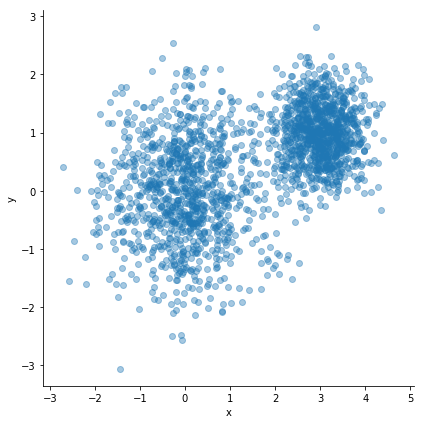

In [18]:
# 데이터 생성
num_points = 2000
vectors_set = []
for i in range(2000):
    if np.random.random() > .5:
        x = np.random.normal(0, .9)
        y = np.random.normal(0, .9)
        vectors_set.append([x, y])
    else:
        x = np.random.normal(3, .5)
        y = np.random.normal(1, .5)
        vectors_set.append([x, y])

# 시각화
df = pd.DataFrame({'x': [v[0] for v in vectors_set], 'y': [v[1] for v in vectors_set]})
sb.lmplot(x='x', y='y', data=df, height=6, fit_reg=False, scatter_kws={'alpha': .4})
plt.show()

In [40]:
# kmeans
vectors = tf.constant(vectors_set)  # 데이터 불러오기
k = 2  # 군집 수 지정

# centroid 초기값 지정. 무작위로 군집 수 만큼 뽑는다.
# 0번째 차원중 k개, 1번째 차원중 2000개 슬라이싱
centroids = tf.Variable(tf.slice(tf.random_shuffle(vectors), [0, 0], [k, -1]))  
print(f'''
shape of vectors: {vectors.get_shape()}
shape of centroids: {centroids.get_shape()}
''')

# 두 벡터의 차원을 맞춘다.
# 크기가 1인 차원은다른 텐서의 해당 차원 크기에 맞춰서 계산한다. 1<->4, 1<->2000
expanded_vectors = tf.expand_dims(vectors, 0)  # 0번째 차원 추가
expanded_centroids = tf.expand_dims(centroids, 1)  # 1번째 차원 추가

print(f'''
shape of expanded vectors: {expanded_vectors.get_shape()}
shape of expanded centroids: {expanded_centroids.get_shape()}
''')

### 각 좌표마다 4개의 중심점까지의 거리를 구하고 가장 거리가 짧은 중심점의 좌표를 출력한다.
# tf.square(tf.subtract(expanded_vectors, expanded_centroids)): 유클리드 제곱거리

# assignments = tf.argmin(tf.reduce_sum(tf.square(tf.subtract(expanded_vectors, expanded_centroids)), 2), 0)
diff = tf.subtract(expanded_vectors, expanded_centroids)
sqr = tf.square(diff)
distance = tf.reduce_sum(sqr, 2)
assignments = tf.argmin(distance, 0)  # 0차원중 값이 제일 작은 index

print(f'''
shape of diff: {diff.get_shape()}
shape of sqr: {sqr.get_shape()}
====reduce_sum은 차원을 축소한다======
shape of distance: {distance.get_shape()}
shape of assignments: {assignments.get_shape()}
''')


### 군집 중심 업데이트
# 0. 모든 클러스터 번호에 대해서(1-4)
    # 1. tf.equal(assignments, cluster): 해당 클러스터와 매칭되는 assigments 텐서의 각 원소 위치를 True로 표시하는 텐서 생성((2000, ))
# 2. tf.tf.where(equal, [1, -1]): True인 위치를 값으로 가지는 텐서 생성((2000, 1))
# 3. 
means = tf.concat([tf.reduce_mean(tf.gather(vectors, 
        tf.reshape(tf.where(tf.equal(assignments, cluster)), [1, -1])), 
        reduction_indices=[1]) for cluster in range(k)], 0)

update_centroids = tf.assign(centroids, means)

init_op = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init_op)

# 100번 반복
for step in range(100):
    _, centroid_values, assignments_values = sess.run([update_centroids, centroids, assignments])
    
print(f'centroids: \n{centroid_values}')


shape of vectors: (2000, 2)
shape of centroids: (2, 2)


shape of expanded vectors: (1, 2000, 2)
shape of expanded centroids: (2, 1, 2)


shape of diff: (2, 2000, 2)
shape of sqr: (2, 2000, 2)
====reduce_sum은 차원을 축소한다======
shape of distance: (2, 2000)
shape of assignments: (2000,)

centroids: 
[[ 2.9569814   0.9661447 ]
 [-0.08309042 -0.05395915]]


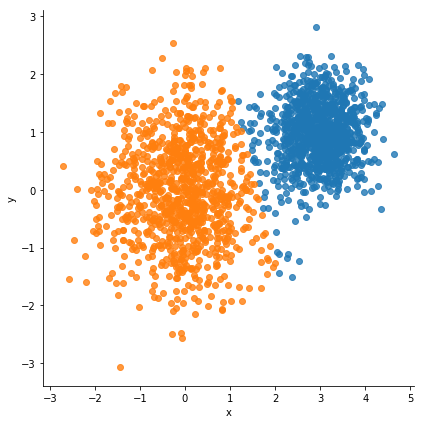

In [41]:
# 시각화
data = {'x': [], 'y': [], 'cluster': []}
for i in range(len(assignments_values)):
    data['x'].append(vectors_set[i][0])
    data['y'].append(vectors_set[i][1])
    data['cluster'].append(assignments_values[i])

df = pd.DataFrame(data)
sb.lmplot(x='x', y='y', data=df, fit_reg=False, hue='cluster', height=6, legend=False)
plt.show()